In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from math import factorial
import math
#%matplotlib qt
%matplotlib inline
name, mass, r, x_pos, y_pos, z_pos = np.loadtxt("Chinchilla_L125_e1.txt",usecols=(0,1,2,6,7,8)).T
simulation_L = 125

def get_axes(data, nonzerocenter = True):
    """
    Method to get axis ratios from subhalos.
    
    Parameters:
        data: Nx3 array of subhalo coordinates, x y z
        nonzerocenter: Boolean; True meaning the halos are centered around the first halo
    """
    
    # define coordinates relative to center halo
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    #print(x)
    
    x = x[1:]-x[0]
    y = y[1:]-y[0]
    z = z[1:]-z[0]

    
    # setup
    M = np.zeros((3,3))
    # print(M)
    
    # calculate elements of tensor
    M[0][0] = np.sum(y**2 + z**2)
    M[1][1] = np.sum(z**2 + x**2)
    M[2][2] = np.sum(x**2 + y**2)
    M[0][1] = M[1][0] = -np.sum(x*y)
    M[0][2] = M[2][0] = -np.sum(x*z)
    M[1][2] = M[2][1] = -np.sum(y*z)
    
    # get eigenvalues + moments of inertia
    eigenvalues, eigenvectors = np.linalg.eig(M)
    I_a = eigenvalues[0] * 5 / x.shape[0]
    I_b = eigenvalues[1] * 5 / x.shape[0]
    I_c = eigenvalues[2] * 5 / x.shape[0]
    
    # calculate axes
    axes = np.zeros(3)
    axes[1] = np.sqrt((I_a - I_b + I_c)/2)
    axes[2] = np.sqrt(I_a - (axes[1]**2))
    axes[0] = np.sqrt(I_c - (axes[1]**2))
    
    #if np.isnan(np.sum(axes)):
        #print(axes)
    
    ordered_axes = np.sort(axes)
    ordered_axes = ordered_axes[::-1]
    
    return ordered_axes

def get_values(index, minmass=0, new_file = None):
    """
    Method to get values from a halo index, and optionally a new file.
    
    Parameters:
        index: int halo index from simulation 
        new_file: string file name 
    """
    
    # allow get_values to access a new file
    if new_file:
        new_name, new_mass, new_r, new_x_pos, new_y_pos, new_z_pos = np.loadtxt(new_file,usecols=(0,1,2,6,7,8)).T
        mask = np.logical_and((new_name==index), (new_mass>minmass))
        mvir, rvir, x, y, z = new_mass[mask], new_r[mask], new_x_pos[mask], new_y_pos[mask], new_z_pos[mask]
    else:
        mask = np.logical_and((name==index), (mass>minmass))
        mvir, rvir, x, y, z = mass[mask], r[mask], x_pos[mask], y_pos[mask], z_pos[mask]
    
    # mask values, incorporates periodic boundary conditions
    mask_x = (x-x[0]>2*rvir[0])
    #print(mask_x)
    x[mask_x]=x[mask_x]-simulation_L
    
    mask_x_case2 = (x[0]-x>2*rvir[0])
    x[mask_x_case2] = simulation_L+x[mask_x_case2]
    
    mask_z = (z-z[0]>2*rvir[0])
    z[mask_z]=z[mask_z]-simulation_L
    
    mask_z_case2 = (z[0]-z>2*rvir[0])
    z[mask_z_case2] = simulation_L+z[mask_z_case2]
    
    mask_y = (y-y[0]>2*rvir[0])
    y[mask_y]=y[mask_y]-simulation_L
    
    mask_y_case2 = (y[0]-y>2*rvir[0])
    y[mask_y_case2] = simulation_L+y[mask_y_case2]
    
    return mvir, rvir, x, y, z

def bootstrap(dataset):
    """
    Method to perform bootstrap sampling on a dataset.
    """
    indices = np.arange(len(dataset))
    random_index = np.random.choice(indices[1:], len(dataset), replace=True)
    random_index[0] = 0
    return dataset[random_index]

def get_statistics(dataset, repetitions, function):
    """
    Method to perform bootstrap sampling repeatedly and calculate some value.
    
    Parameters:
        dataset: any array
        repetitions: number of times to repeat sampling 
        function: any function returning a numeric value
    """
    
    all_axes = []
    
    # for each sample, calculate axes
    for i in range(repetitions):
        sample = bootstrap(dataset)
        output = function(sample)
        all_axes.append(output)
    
    # return all axes
    return np.array(all_axes)

def get_quantiles(data):
    """
    Method to get 1sigma, 2sigma, 3sigma quantiles + median from 1D data
    """
    quantiles = {'median': np.quantile(data,0.5),
                 '1sigma': [np.quantile(data,0.159),np.quantile(data,0.841)],
                 '2sigma': [np.quantile(data, 0.023),np.quantile(data,0.977)],
                 '3sigma': [np.quantile(data,0.002),np.quantile(data,0.998)]}
    return quantiles

def crossmatch(halos):
    """
    Matches halos between simulations by mass.
    
    Parameters: 
        halos: 2D array of halos from a simulation with Nx6 arrays each (0=name, 1=mass, 2=rvir, 3=x, 4=y, 5=z)
        
    Output: 2D array of names (halo & matched halo)
    """
    size = halos[0].shape[0]
    halos[0] = halos[0][halos[0][:,1].argsort()]
    x_cm = np.zeros((size,len(halos)))
    y_cm = np.zeros((size,len(halos)))
    z_cm = np.zeros((size,len(halos)))
    m_cm = np.zeros((size,len(halos)))
    names = np.zeros((size, len(halos)))
    
    x_cm[:, 0] = halos[0][:,3]
    y_cm[:, 0] = halos[0][:,4]
    z_cm[:, 0] = halos[0][:,5]
    m_cm[:, 0] = halos[0][:,1]
    names[:, 0] = halos[0][:,0]
    
    current_halo = halos[0] #the base simulation
    for j in range(halos[0].shape[0]):
        distances = np.zeros((size, len(halos)-1))
        for i in range(len(halos)-1):
            halo_counter = i+1
            
            distances_x = [(current_halo[j,3]-halos[halo_counter][:,3])**2, (125-(current_halo[j,3]-halos[halo_counter][:,3]))**2, (125-(halos[halo_counter][:,3]-current_halo[j,3]))**2]
            xdist = np.array([min(idx) for idx in zip(*distances_x)]) 
            distances_y = [(current_halo[j,4]-halos[halo_counter][:,4])**2, (125-(current_halo[j,4]-halos[halo_counter][:,4]))**2, (125-(halos[halo_counter][:,4]-current_halo[j,4]))**2]
            ydist = np.array([min(idx) for idx in zip(*distances_y)])
            distances_z = [(current_halo[j,5]-halos[halo_counter][:,5])**2, (125-(current_halo[j,5]-halos[halo_counter][:,5]))**2, (125-(halos[halo_counter][:,5]-current_halo[j,5]))**2]
            zdist = np.array([min(idx) for idx in zip(*distances_z)])
            
            # report bad matches
            distances[:, i] = np.sqrt(xdist+ydist+zdist)
            if np.min(distances[:,i]) > current_halo[j,2]:
                print('No good matches for halo '+str(current_halo[j,0])+' in simulation '+str(halo_counter))
            
            #print(halos[halo_counter][:,3])
            #print(distances)
            
        indices = np.argmin(distances, axis=0)
        #print(indices)
        
        
        for i in range(len(halos)-1):
            halo_counter = i+1
            names[j, halo_counter] = halos[halo_counter][indices[i],0]
            m_cm[j, halo_counter] = halos[halo_counter][indices[i],1]
            x_cm[j, halo_counter] = halos[halo_counter][indices[i],3]
            y_cm[j, halo_counter] = halos[halo_counter][indices[i],4]
            z_cm[j, halo_counter] = halos[halo_counter][indices[i],5]
        
    return names, m_cm, x_cm, y_cm, z_cm

def get_halo_lists(filename):
    """
    Method to get formatted halo lists from a file.
    
    Parameters:
        filename: halo catalog file as a string
    
    Output: M-dimensional (M = # halos) list of Nx6 arrays (name, m, r, x, y, z)
    """
    halos = np.loadtxt(filename,usecols=(0,1,2,6,7,8))
    indices = np.unique(halos[:, 0],return_index=True)
    return halos[indices[1]]

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
 
def random_sphere(N):
    """ random_sphere returns the azimuthal angle, phi, and polar angle, theta
    of N points generated uniformly at random over the surface of a sphere.
    """
    # See https://mathworld.wolfram.com/SpherePointPicking.html for the
    # algorithm. (Basically just the Inverse Transfer Method.)
    phi = 2*np.pi*random.random(N)
    theta = np.arccos(2*random.random(N) - 1)
    return phi, theta
 
def spherical_to_cartesian(phi, theta, r):
    """ spherical_to_cartesian converts spherical coordiantes to cartesian
    coordinates. Here, phi is the azimuthal angle, theta is the polar angle, and
    r is the radius.
    """
    # See https://mathworld.wolfram.com/SphericalCoordinates.html, but note the
    # difference in convention.
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return x, y, z
 
def random_ball(N, R):
    """ random_ball returns a N points (x, y, z) generated uniformly at
    random from within a ball of radius r.
    """
    phi, theta = random_sphere(N)
    # Inverse Transform Method, See
    # http://www.columbia.edu/~ks20/4404-Sigman/4404-Notes-ITM.pdf
    r = random.random(N)**(1.0/3) * R
    return spherical_to_cartesian(phi, theta, r)
    
def random_ellipsoid(N, a, b, c):
    """ random_ellipsoid returns N points generated uniformly at random inside
    an ellipsoid. The axes of the ellipsoid are given by (a, b, c) which
    are aligned with the x, y, and z axes, respectively.
    """
    x, y, z = random_ball(N, 1.0)
    x[0] = 0
    y[0] = 0
    z[0] = 0
    return x*a, y*b, z*c

In [2]:
def get_angle(center, pairs_of_points):
    """
    Method to get the angle in 3D space between two points.
    Input: center coordinates, 2xM numpy array of point pairs
    Return: M-length array of angles
    """
    angles = np.zeros(pairs_of_points.shape[0])
    
    for i in range(pairs_of_points.shape[0]):
        #print(pairs_of_points[i])
        a = pairs_of_points[i, 0]
        b = center
        c = pairs_of_points[i, 1]
        
        ba = a - b
        bc = c - b

        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
        
        if np.isnan(np.degrees(angle)):
            angles[i] = 180.
        else:
            angles[i] = np.degrees(angle)
    
    return angles

In [3]:
def get_combinations_of_points(halo, minmassratio):
    """
    Method to get all pairs of satellites' coordinates given a halo and mass ratio.
    """
    
    mvir, rvir, x, y, z = get_values(halo)
    mvir, rvir, x, y, z = get_values(halo, mvir[0] * minmassratio)
    
    #fig = plt.figure(figsize=(10,10))
    #ax = fig.add_subplot(111, projection='3d')
    #print(x,y,z)
    
    x = x-x[0]
    
    y = y-y[0]
    
    z = z-z[0]
    
    center = np.array([x[0],y[0],z[0]])
    x = x[1:]
    y = y[1:]
    z = z[1:]
    
    #print(len(x))
    #ax.scatter(x,y,z, zdir='z', s=500, c='r')
    #ax.scatter(center[0], center[1], center[2], zdir='z', s=1500, c='k')
    
    pairs_of_points = np.zeros((int((x.shape[0] * (x.shape[0]-1))/2), 2, 3))
    
    counter = 0
    for i in range(x.shape[0]):
        for k in range(x.shape[0]-i):
            j = k + i
            
            if j != i:
                #print(i,j)
                pairs_of_points[counter, 0] = np.array([x[i],y[i],z[i]])
                pairs_of_points[counter, 1] = np.array([x[j],y[j],z[j]])
                
                counter+=1

    #print(pairs_of_points.shape[0])
    return center, pairs_of_points
    

In [4]:
def get_combinations_of_points_2(data):
    """
    Method to get all pairs of satellites' points given a Nx3 list of coordinates.
    """
    
    x_=data[:,0]
    y_=data[:,1]
    z_=data[:,2]
    x_ = x_-x_[0]   
    y_ = y_-y_[0]    
    z_ = z_-z_[0]
    center = np.array([x_[0],y_[0],z_[0]])
    x_ = x_[1:]
    y_ = y_[1:]
    z_ = z_[1:]
    
    #print(len(x))
    #ax.scatter(x,y,z, zdir='z', s=500, c='r')
    #ax.scatter(center[0], center[1], center[2], zdir='z', s=1500, c='k')
    
    pairs_of_points = np.zeros((int((x_.shape[0] * (x_.shape[0]-1))/2), 2, 3))
    
    counter = 0
    for i in range(x_.shape[0]):
        for k in range(x_.shape[0]-i):
            j = k + i
            
            if j != i:
                #print(i,j)
                pairs_of_points[counter, 0] = np.array([x_[i],y_[i],z_[i]])
                pairs_of_points[counter, 1] = np.array([x_[j],y_[j],z_[j]])
                
                counter+=1

    #print(pairs_of_points.shape[0])
    return center, pairs_of_points
    

In [5]:
def get_mean_angle(data):
    """
    Method to get mean angle between satellites.
    Input: Nx3 array of coordinates.
    """
    center, pairs_of_points = get_combinations_of_points_2(data)
    angles = get_angle(center, pairs_of_points)
    return np.mean(angles)


def get_ca(data):
    """
    Method to get axis ratio c/a.
    Input: Nx3 array of coordinates.
    """
    a, b, c = get_axes(data)
    return c/a

def get_mean_pos(data):
    """
    Method to get mean satellite position (subtracted from center).
    Input: Nx3 array of coordinates.
    """
    return np.mean(np.abs(data[1:]-data[0]), axis=0)

def get_mean_dist(data):
    """
    Method to get mean distance from center.
    Input: Nx3 array of coordinates.
    """
    xdist, ydist, zdist = get_mean_pos(data)
    return np.sqrt(xdist**2 + ydist**2 + zdist**2)

In [6]:
def get_combinations_of_points_ellipsoid(n,a,b,c):
    """
    Method to get all combinations of points in a random ellipsoid.
    """
    
    x, y, z = random_ellipsoid(n,a,b,c)
    center = np.array([x[0],y[0],z[0]])
    x = x[1:]
    y = y[1:]
    z = z[1:]
    
    #ax.scatter(x,y,z, zdir='z', s=500, c='r')
    #ax.scatter(center[0], center[1], center[2], zdir='z', s=1500, c='k')
    
    pairs_of_points = np.zeros((int((x.shape[0] * (x.shape[0]-1))/2), 2, 3))
    
    counter = 0
    for i in range(x.shape[0]):
        for k in range(x.shape[0]-i):
            j = k + i
            
            if j != i:
                #print(i,j)
                pairs_of_points[counter, 0] = np.array([x[i],y[i],z[i]])
                pairs_of_points[counter, 1] = np.array([x[j],y[j],z[j]])
                
                counter+=1

            
    return center, pairs_of_points
    

In [7]:
names, m_cm, x_cm, y_cm, z_cm = crossmatch([get_halo_lists("Chinchilla_L125_e1.txt"), get_halo_lists("Chinchilla_L125_e2.txt"), get_halo_lists("Chinchilla_L125_e5.txt"), get_halo_lists("Chinchilla_L125_e14.txt")])

No good matches for halo 250374.0 in simulation 1
No good matches for halo 250374.0 in simulation 2


In [137]:
names[48]

array([480874., 485647., 482997., 439562.])

In [8]:
%matplotlib inline
# calculate axis ratios as a function of minmass for an individual halo
axis_vals_a = [1,2,5,10]
values_ellipsoid = []

# setup, file = index of the halo (ranked by mass)
for i in range(len(axis_vals_a)):
    center, pairs_of_points = get_combinations_of_points_ellipsoid(300,axis_vals_a[i],1,1)
    angles = get_angle(center, pairs_of_points)
    values_ellipsoid.append(angles)

In [9]:
# prolate
%matplotlib inline
# calculate axis ratios as a function of minmass for an individual halo
vals_ca = np.linspace(0.1,0.9,20)
values_prolate_sds = []
values_prolate = []

# setup, file = index of the halo (ranked by mass)
for i in range(len(vals_ca)):
    center, pairs_of_points = get_combinations_of_points_ellipsoid(100,1,1,vals_ca[i])
    angles = get_angle(center, pairs_of_points)
    values_prolate.append(angles)
    values_prolate_sds.append(np.std(angles))

In [10]:
# prolate
%matplotlib inline
# calculate axis ratios as a function of minmass for an individual halo
vals_ca = np.linspace(0.1,0.9,20)
values_oblate_sds = []
values_oblate = []

# setup, file = index of the halo (ranked by mass)
for i in range(len(vals_ca)):
    center, pairs_of_points = get_combinations_of_points_ellipsoid(100,1,vals_ca[i],vals_ca[i])
    angles = get_angle(center, pairs_of_points)
    values_oblate.append(angles)
    values_oblate_sds.append(np.std(angles))

Text(0.5, 0, 'c/a')

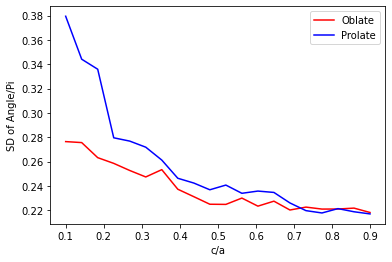

In [11]:
plt.plot(vals_ca, np.divide(np.radians(values_prolate_sds),math.pi), c='r',label='Oblate')
plt.plot(vals_ca, np.divide(np.radians(values_oblate_sds),math.pi), c='b',label='Prolate')
plt.legend()
plt.ylabel('SD of Angle/Pi')
plt.xlabel('c/a')

# Satellites: 13
13


Text(0.5, 0, 'z')

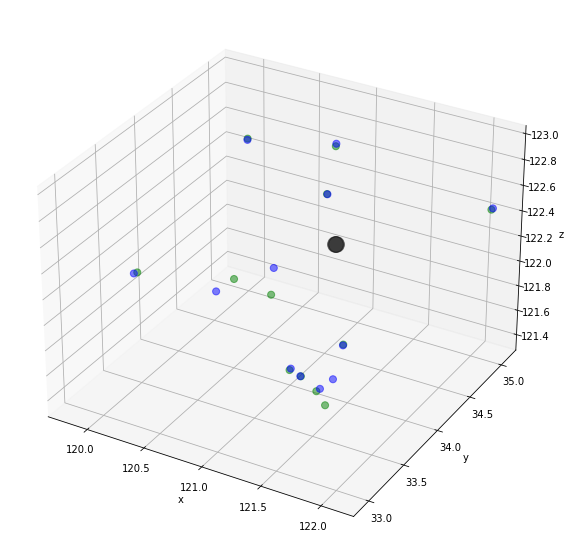

In [157]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

mvir, rvir, x, y, z = get_values(480874, 5e11, new_file='Chinchilla_L125_e1.txt')
print("# Satellites: {}".format(len(x)))
ax.scatter(x[0], y[0], z[0], zdir='z', s=250, c='k', alpha=0.5)
ax.scatter(x[1:], y[1:], z[1:], zdir='z', s=50, c='b', alpha=0.5)

mvir, rvir, x, y, z = get_values(485647, 5e11, new_file='Chinchilla_L125_e2.txt')
print(len(x))
ax.scatter(x[0], y[0], z[0], zdir='z', s=250, c='k', alpha=0.5)
ax.scatter(x[1:], y[1:], z[1:], zdir='z', s=50, c='g', alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [181]:
%matplotlib inline
# calculate axis ratios as a function of minmass for an individual halo
n_files = 4
min_val = 10**-3
epsilon_vals = [1, 2,5,14]
halos = names[48]
values = []

# setup, file = index of the halo (ranked by mass)
for i in range(n_files):
    name, mass, r, x_pos, y_pos, z_pos = np.loadtxt('Chinchilla_L125_e'+str(epsilon_vals[i])+'.txt',usecols=(0,1,2,6,7,8)).T
    print(epsilon_vals[i])
    
    halo = int(halos[i])
    center, pairs_of_points = get_combinations_of_points(halo, min_val)
    angles = get_angle(center, pairs_of_points)
    values.append(angles)
    print('# Angles: {}'.format(angles.shape[0]))

1
# Angles: 66
2
# Angles: 66
5
# Angles: 55
14
# Angles: 45


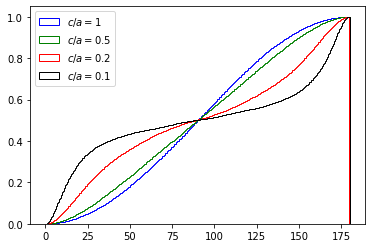

In [180]:
# angle distributions for ellipsoids
plt.hist(values_ellipsoid[0],histtype="step",color='b',cumulative=True, density=True, bins=500,label=r'$c/a = 1$')
plt.hist(values_ellipsoid[1],histtype="step",color='g',cumulative=True, density=True, bins=500,label=r'$c/a = 0.5$')
plt.hist(values_ellipsoid[2],histtype="step",color='r',cumulative=True, density=True, bins=500,label=r'$c/a = 0.2$')
plt.hist(values_ellipsoid[3],histtype="step",color='k',cumulative=True, density=True, bins=500,label=r'$c/a = 0.1$')


plt.legend(loc='upper left')
plt.show()

Text(0.5, 0, 'Angle (degrees)')

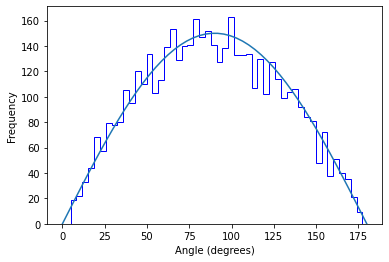

In [130]:
plt.hist(values_ellipsoid[0],histtype="step",color='b', bins=50,label=r'$c/a = 1$')
xangle = np.linspace(0,180,50)
plt.plot(xangle,np.sin(math.pi*xangle/180)*150)
plt.ylabel('Frequency')
plt.xlabel('Angle (degrees)')

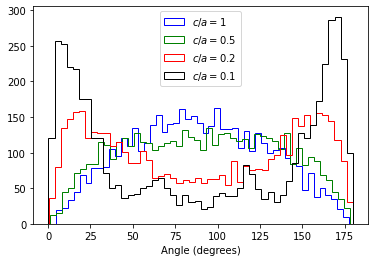

In [167]:
# angle distributions for ellipsoids
plt.hist(values_ellipsoid[0],histtype="step",color='b', bins=50,label=r'$c/a = 1$')
plt.hist(values_ellipsoid[1],histtype="step",color='g', bins=50,label=r'$c/a = 0.5$')
plt.hist(values_ellipsoid[2],histtype="step",color='r',bins=50,label=r'$c/a = 0.2$')
plt.hist(values_ellipsoid[3],histtype="step",color='k', bins=50,label=r'$c/a = 0.1$')
plt.xlabel('Angle (degrees)')

plt.legend(loc='upper center')
plt.show()

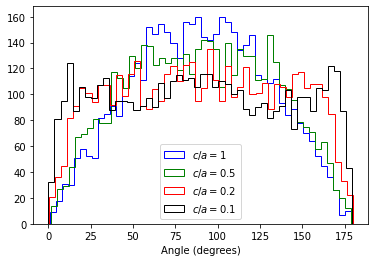

In [172]:
# angle distributions for ellipsoids, prolate
plt.hist(values_ellipsoid[0],histtype="step",color='b', bins=50,label=r'$c/a = 1$')
plt.hist(values_ellipsoid[1],histtype="step",color='g', bins=50,label=r'$c/a = 0.5$')
plt.hist(values_ellipsoid[2],histtype="step",color='r',bins=50,label=r'$c/a = 0.2$')
plt.hist(values_ellipsoid[3],histtype="step",color='k', bins=50,label=r'$c/a = 0.1$')
plt.xlabel('Angle (degrees)')

plt.legend(loc='lower center')
plt.show()

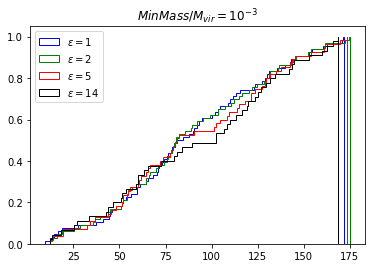

In [182]:
# angle distributions for satellites for 480874., 485647., 482997., 439562.
plt.hist(values[0],histtype="step",color='b',cumulative=True, density=True, bins=500,label=r'$\varepsilon=1$')
plt.hist(values[1],histtype="step",color='g',cumulative=True, density=True, bins=500,label=r'$\varepsilon=2$')
plt.hist(values[2],histtype="step",color='r',cumulative=True, density=True, bins=500,label=r'$\varepsilon=5$')
plt.hist(values[3],histtype="step",color='k',cumulative=True, density=True, bins=500,label=r'$\varepsilon=14$')

plt.title(r'$MinMass/M_{vir} = 10^{-3}$')
plt.legend(loc='upper left')
plt.show()

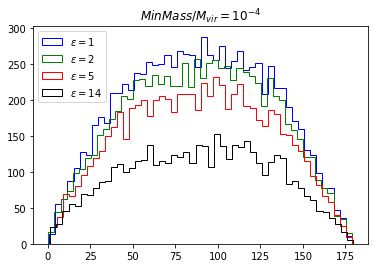

In [164]:
# angle distributions for satellites for 480874., 485647., 482997., 439562.
plt.hist(values[0],histtype="step",color='b', bins=50,label=r'$\varepsilon=1$')
plt.hist(values[1],histtype="step",color='g', bins=50,label=r'$\varepsilon=2$')
plt.hist(values[2],histtype="step",color='r', bins=50,label=r'$\varepsilon=5$')
plt.hist(values[3],histtype="step",color='k', bins=50,label=r'$\varepsilon=14$')

plt.title(r'$MinMass/M_{vir} = 10^{-4}$')
plt.legend(loc='upper left')
plt.show()

In [253]:
%matplotlib inline
n_files = 4
n = np.logspace(-5,-2,num=100)
epsilon_vals = [1, 2,5,14]
sizes = np.zeros((50,4))

# setup, file = index of the halo (ranked by mass)
for i in range(n_files):
    name, mass, r, x_pos, y_pos, z_pos = np.loadtxt('Chinchilla_L125_e'+str(epsilon_vals[i])+'.txt',usecols=(0,1,2,6,7,8)).T
    for j in range(50):
        halo = int(names[j,i])
        m, radius, x, y, z = get_values(halo)
        sizes[j,i] = m.shape[0]-1

In [257]:
np.mean(sizes,axis=0)

array([255.18, 248.08, 224.12, 148.36])

(array([15., 14.,  9.,  2.,  2.,  3.,  1.,  2.,  1.,  1.]),
 array([ 68. , 101.1, 134.2, 167.3, 200.4, 233.5, 266.6, 299.7, 332.8,
        365.9, 399. ]),
 [<matplotlib.patches.Polygon at 0x7f86f7763390>])

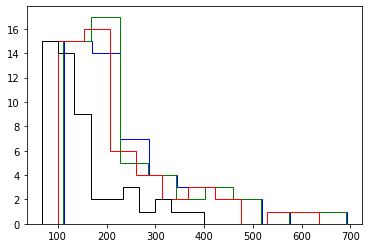

In [258]:
plt.hist(sizes[:,0],histtype='step',color='b')
plt.hist(sizes[:,1],histtype='step',color='g')
plt.hist(sizes[:,2],histtype='step',color='r')
plt.hist(sizes[:,3],histtype='step',color='k')

In [259]:
%matplotlib inline
n_files = 4
n = np.logspace(-5,-2,num=100)
epsilon_vals = [1, 2,5,14]
halos = names[45]
sizes = np.zeros((100,4))

# setup, file = index of the halo (ranked inverse by mass)
for i in range(n_files):
    halo = halos[i]
    name, mass, r, x_pos, y_pos, z_pos = np.loadtxt('Chinchilla_L125_e'+str(epsilon_vals[i])+'.txt',usecols=(0,1,2,6,7,8)).T
    m, radius, x, y, z = get_values(halo)
    print(m[0])
    print('Total # Halos: {}'.format(m.shape[0]))

    for j in range(len(n)):
        m, radius, x, y, z = get_values(halo, minmass=n[j]*m[0])
        sizes[j,i] = m.shape[0]-1

317000000000000.0
Total # Halos: 453
319000000000000.0
Total # Halos: 432
319000000000000.0
Total # Halos: 413
319000000000000.0
Total # Halos: 263


Text(0.5, 0, '$MinMass/M_{vir}$')

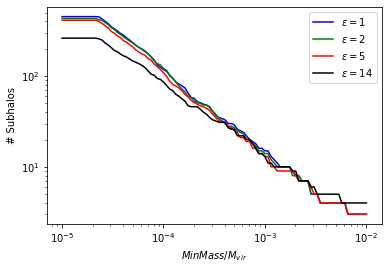

In [260]:
plt.plot(n, sizes[:,0], c='b',label=r'$\varepsilon=1$')
plt.plot(n, sizes[:,1], c='g',label=r'$\varepsilon=2$')
plt.plot(n, sizes[:,2], c='r',label=r'$\varepsilon=5$')
plt.plot(n, sizes[:,3], c='k',label=r'$\varepsilon=14$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('# Subhalos')
plt.legend()
plt.xlabel(r'$MinMass/M_{vir}$')

In [58]:
get_values(480875,0.01*(2.6e+14))

(array([2.60e+14, 6.41e+12, 3.23e+12]),
 array([1.311, 0.382, 0.304]),
 array([121.516, 121.752, 121.328]),
 array([40.476, 41.688, 40.004]),
 array([122.87 , 122.627, 123.557]))

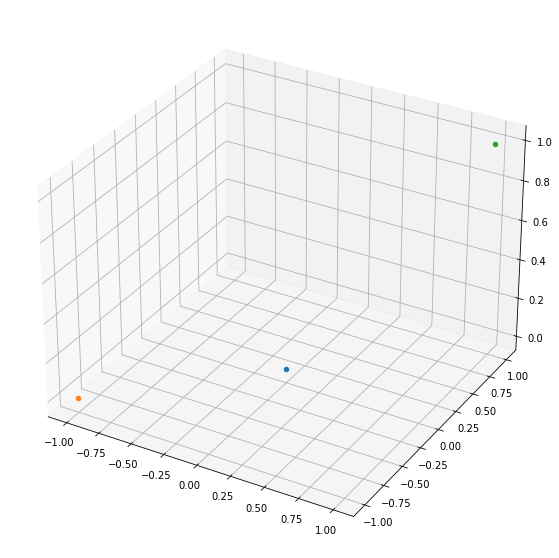

In [204]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0,0,0)
ax.scatter(-1,-1,0)
ax.scatter(1,1,1)

In [203]:
points = np.array([[[-1,-1,0],[1,1,1]]])
get_angle([0,0,0], points)

array([144.73561032])

In [295]:
x, y, z = random_ellipsoid(100,1,1,1)

In [296]:
get_mean_angle(np.array([x,y,z]).T)

89.0262734628589

In [44]:
# method to calculate ellipsoid axes
def get_axes_directions(data, nonzerocenter = True):
    # define coordinates relative to center halo
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    
    if nonzerocenter:
        x = x[1:]-x[0]
        y = y[1:]-y[0]
        z = z[1:]-z[0]
    
    # setup
    M = np.zeros((3,3))
    # print(M)
    
    # calculate elements of tensor
    M[0][0] = np.sum(y**2 + z**2)
    M[1][1] = np.sum(z**2 + x**2)
    M[2][2] = np.sum(x**2 + y**2)
    M[0][1] = M[1][0] = -np.sum(x*y)
    M[0][2] = M[2][0] = -np.sum(x*z)
    M[1][2] = M[2][1] = -np.sum(y*z)
    
    # get eigenvalues + moments of inertia
    eigenvalues, eigenvectors = np.linalg.eig(M)
   
    
    return eigenvectors

In [90]:
x, y, z = random_ellipsoid(100,1,1,1)
print(get_axes_directions(np.array([x,y,z]).T))

[[-0.4646218   0.75792397  0.45790592]
 [ 0.28421852  0.61739167 -0.73351711]
 [ 0.83865751  0.2106627   0.50226966]]


In [96]:
mm, rr, x, y, z = get_values(480875)
print(get_axes_directions(np.array([x,y,z]).T))

[[ 0.270212    0.88342181  0.3828203 ]
 [ 0.93922623 -0.15441474 -0.3066108 ]
 [ 0.21175357 -0.44240479  0.87145765]]


In [164]:
def get_dphi(data, get_combinations = True):
    polar_direction = get_axes_directions(data)[2]
    phis = np.zeros(data.shape[0]-1)
    if get_combinations:
        center, pairs_of_points = get_combinations_of_indices(data)
    else:
        center = data[0]
    
    a = polar_direction + center
    b = center
    
    for i in range(data.shape[0]-1):
        # 0th halo is the center
        j = i+1   
        
        c = data[j,:]
        
        ba = a - b
        bc = c - b

        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
        
        if np.isnan(np.degrees(angle)):
            phis[i] = 180.
        else:
            phis[i] = np.degrees(angle)
    
    angles = []
    if get_combinations:
        angles = np.zeros(pairs_of_points.shape[0])
        for i in range(pairs_of_points.shape[0]):
            indices_pair = pairs_of_points[i]
            angles[i] = np.abs(phis[int(indices_pair[0])] - phis[int(indices_pair[1])])
    
    return angles, phis

In [111]:
polar_direction = np.array([1,0,0])
center = np.array([0,0,0])
point = np.array([0,1,0])

In [112]:
a = polar_direction + center
b = center
c = point

ba = a - b
bc = c - b

cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
angle = np.arccos(cosine_angle)

print(np.degrees(angle))

90.0


In [113]:
def get_combinations_of_indices(data):
    """
    Method to get all pairs of satellites' points given a Nx3 list of coordinates.
    """

    center = data[0]
    data = data[1:]
    num = data.shape[0]
    
    pairs_of_points = np.zeros((int(num * (num-1)/2), 2))
    
    counter = 0
    for i in range(num):
        for k in range(num-i):
            j = k + i
            
            if j != i:
                pairs_of_points[counter, 0] = i
                pairs_of_points[counter, 1] = j
                
                counter+=1

    return center, pairs_of_points

In [165]:
x, y, z = random_ellipsoid(100,1,1,1)
dphis, phis = get_dphi(np.array([x,y,z]).T, get_combinations=True)

In [161]:
x, y, z = random_ellipsoid(100,1,1,0.7)
dphis2, phis2 = get_dphi(np.array([x,y,z]).T,get_combinations=True)

In [160]:
x, y, z = random_ellipsoid(100,1,1,0.5)
dphis3, phis3 = get_dphi(np.array([x,y,z]).T,get_combinations=True)

In [159]:
x, y, z = random_ellipsoid(100,1,1,0.2)
dphis4, phis4 = get_dphi(np.array([x,y,z]).T,get_combinations=True)

Text(0, 0.5, 'Angle Formed w/ Minor Axis c (degrees)')

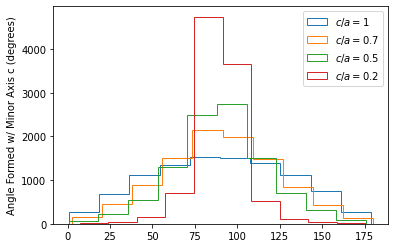

In [156]:
plt.hist(phis, histtype='step', label=r'$c/a=1$')
plt.hist(phis2, histtype='step', label=r'$c/a=0.7$')
plt.hist(phis3, histtype='step', label=r'$c/a=0.5$')
plt.hist(phis4, histtype='step', label=r'$c/a=0.2$')
plt.legend()
plt.ylabel('Angle Formed w/ Minor Axis c (degrees)')

Text(0, 0.5, 'Polar Angle Difference (degrees)')

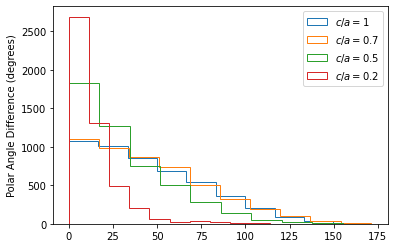

In [168]:
plt.hist(dphis, histtype='step', label=r'$c/a=1$')
plt.hist(dphis2, histtype='step', label=r'$c/a=0.7$')
plt.hist(dphis3, histtype='step', label=r'$c/a=0.5$')
plt.hist(dphis4, histtype='step', label=r'$c/a=0.2$')
plt.legend()
plt.ylabel('Polar Angle Difference (degrees)')

In [158]:
dphis

[]